**Glow normalizing flow**

notebook made by: Anas Aldadi


<img src="https://drive.google.com/uc?id=1Qt_lqfpJfQ9ZderZzNGM3hoLnbmk1iIN" width="800">

we'll build it block by block using pytorch primitives and as simple as possible (without LU decompsition) but the results are bad and can only scale results of MNIST

if we want to generate high resolution faces from CelebAHQ dataset we need to do some other tricks which i took from a [repo](https://github.com/rosinality/glow-pytorch)

Glow builds upon the previous invertible generative models, NICE and RealNVP, and simplifies the architecture by replacing the reverse permutation operation on the channel ordering with Invertible 1x1 Convolutions. [ref](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Advanced_Generative_Models/Normalizing_flows/advancednormflow.html)

Its famous because it was the first flow based model that generates high resolution images and also enables latent manipulations!! which later we will play around.

**Pros (+)**

* Good introduction to normalizing flows, was easy to implement from reading the paper
* Fully-reversible model: Nice interpretation in the encoder/decoder framework
* High-quality samples for a VAE based model

**Cons (-)**

* High memory requirements (fully-reversible means no loss of information)
* Slow training times

[ref](https://ameroyer.github.io/portfolio/2021-04-12-Glow/)

good references:
* [to recap jacobians and determinants](https://lilianweng.github.io/posts/2018-10-13-flow-models/)
* [nice blog i understood alot from it](https://ameroyer.github.io/portfolio/2021-04-12-Glow/)

## Reqs

In [ ]:
import gdown
folder_id = "15qKGWnJo6NGpVdU6u3tbpG68KpuM_EtC"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 1Qt_lqfpJfQ9ZderZzNGM3hoLnbmk1iIN 00.jpg
Processing file 1XjKO4qzFNMyUbN-AAEYDlinQMwgy2WWv glow_bb.png
Processing file 1wHZkDQ-KUvCgrY_bOzlH-5NSgo6wavRq glow.png
Processing file 1V2hMJpMXNGNZz6gCJGaVR658J0qxZimd invertible.png
Processing file 1IcnBb0OaEJMp-q1tteolhMCQhRW1fKgy model_000002.pt
Processing file 1-2XiJVRT0LdnL41dX-f6Da-X-b7QulQ2 model_004001.pt
Processing file 1-8tR3AJD39q8krENlw-BqTV5HiVdzVre model_005001.pt
Processing file 1-vCxg1HGa2BDghWMKqpmh6YMxqCq6GlS optim_000002.pt
Processing file 1tndTsiXdI3JtPxX8dO1Eznkg3jy9gbzr optim_004001.pt
Processing file 1-5OM9WirG5Wzn1N1A1H4oIYCUcMmh79H optim_005001.pt
Processing file 13xSQKeJ1Ina1q9ZId509vPHy1G-Oibh0 pitfall.png
Processing file 10z0iRaNZLM_9_Y3uAEpKKk0S2asesfTt progression.gif
Processing file 1j6S3BcJ8DH3LYH6gHBtf-W9uyAFZCOFq split.png
Processing file 1WYPw7wx4i7N6R2vXhQn-lc7I-tcG2Wjn training_glow.gif
Processing file 1EX9t0ES2MqX_u1BW9rF_mMgZrUtEe7nU transition.png


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Qt_lqfpJfQ9ZderZzNGM3hoLnbmk1iIN
To: /content/glow/00.jpg
100%|██████████| 211k/211k [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XjKO4qzFNMyUbN-AAEYDlinQMwgy2WWv
To: /content/glow/glow_bb.png
100%|██████████| 34.6k/34.6k [00:00<00:00, 40.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wHZkDQ-KUvCgrY_bOzlH-5NSgo6wavRq
To: /content/glow/glow.png
100%|██████████| 753k/753k [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V2hMJpMXNGNZz6gCJGaVR658J0qxZimd
To: /content/glow/invertible.png
100%|██████████| 94.5k/94.5k [00:00<00:00, 83.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1IcnBb0OaEJMp-q1tteolhMCQhRW1fKgy
From (redirected): https://drive.google.com/uc?id=1IcnBb0OaEJMp-q1tteolhMCQhRW1fKgy&confirm=t&uuid=6e8984b3-8791-40d3-881d-01825249f3

['/content/glow/00.jpg',
 '/content/glow/glow_bb.png',
 '/content/glow/glow.png',
 '/content/glow/invertible.png',
 '/content/glow/model_000002.pt',
 '/content/glow/model_004001.pt',
 '/content/glow/model_005001.pt',
 '/content/glow/optim_000002.pt',
 '/content/glow/optim_004001.pt',
 '/content/glow/optim_005001.pt',
 '/content/glow/pitfall.png',
 '/content/glow/progression.gif',
 '/content/glow/split.png',
 '/content/glow/training_glow.gif',
 '/content/glow/transition.png']

In [ ]:
import torch, torchvision

# torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision import datasets, transforms, utils

# Others
import glob, re, shutil, os, gc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from types import SimpleNamespace
from math import log, sqrt, pi
import argparse
from IPython.display import Image as IPyImage, display
import random
import time

In [ ]:
print(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [ ]:
os.environ['KAGGLEHUB_CACHE'] = '/content/data'

In [ ]:
eps = 1e-6
counter=1

## Helpers

In [ ]:
def manipulate_attribute_from_path(
    model,
    dataset,
    image_path,
    attr_index,
    attr_value_pos,
    attr_value_neg=None,
    n_pos=50,
    n_neg=50,
    alphas=None,
    device='cuda'
):
    import torch
    import torchvision.transforms as T
    import matplotlib.pyplot as plt
    from PIL import Image

    if alphas is None:
        alphas = [-0.5, 0.0, 0.5, 1.0, 1.5]

    model.eval()

    # --- Subset selection ---
    def select_subset(dataset, attr_index, attr_value, max_samples=100):
        subset = []
        for i in range(len(dataset)):
            img, attr = dataset[i]
            if attr[attr_index].item() == attr_value:
                subset.append(img.unsqueeze(0))
            if len(subset) >= max_samples:
                break
        return subset

    def select_neg_subset(dataset, attr_index, pos_value, max_samples=100):
        subset = []
        for i in range(len(dataset)):
            img, attr = dataset[i]
            if attr[attr_index].item() != pos_value:
                subset.append(img.unsqueeze(0))
            if len(subset) >= max_samples:
                break
        return subset

    X_pos = select_subset(dataset, attr_index, attr_value_pos, n_pos)
    X_neg = (
        select_subset(dataset, attr_index, attr_value_neg, n_neg)
        if attr_value_neg is not None
        else select_neg_subset(dataset, attr_index, attr_value_pos, n_neg)
    )

    # --- Encode latents ---
    def encode_latents(model, batch):
        with torch.no_grad():
            z_list = []
            for x in batch:
                z_outs = model(x.to(device))[2]
                z_list.append(z_outs)
        return z_list

    def average_latents(z_batch):
        n_levels = len(z_batch[0])
        return [torch.stack([z[i] for z in z_batch]).mean(dim=0) for i in range(n_levels)]

    z_pos = average_latents(encode_latents(model, X_pos))
    z_neg = average_latents(encode_latents(model, X_neg))
    z_direction = [zp - zn for zp, zn in zip(z_pos, z_neg)]

    # --- Preprocess and load custom image ---
    preprocess = T.Compose([
        T.Resize((64, 64)),
        T.ToTensor(),  # range [0, 1]
    ])
    x_input = preprocess(Image.open(image_path).convert('RGB')).to(device)

    # --- Manipulate input across alphas ---
    def manipulate(model, x_input, z_direction, alpha):
        with torch.no_grad():
            z_input = model(x_input.unsqueeze(0))[2]
            z_mod = [zi + alpha * d for zi, d in zip(z_input, z_direction)]
            x_output = model.reverse(z_mod)
        return x_output.squeeze(0).cpu()

    manipulated_images = [manipulate(model, x_input, z_direction, alpha) for alpha in alphas]

    # --- Plot results ---
    plt.figure(figsize=(len(alphas) * 2, 3))
    for i, (img, alpha) in enumerate(zip(manipulated_images, alphas)):
        plt.subplot(1, len(alphas), i + 1)
        img = img.clamp(0, 1)
        plt.imshow(img.detach().permute(1, 2, 0))
        plt.title(f"α={alpha}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
def interpolate_faces_dataset(model, dataset, index1, index2, num_steps=7, device='cuda'):
    import torch
    import matplotlib.pyplot as plt

    model.eval()

    # Load and encode both images
    x1, _ = dataset[index1]
    x2, _ = dataset[index2]

    with torch.no_grad():
        z1 = model(x1.unsqueeze(0).to(device))[2]
        z2 = model(x2.unsqueeze(0).to(device))[2]

    # Generate interpolations in latent space
    interpolated_images = []
    for alpha in torch.linspace(0, 1, steps=num_steps):
        z_interp = [(1 - alpha) * z1i + alpha * z2i for z1i, z2i in zip(z1, z2)]
        x_interp = model.reverse(z_interp).squeeze(0).cpu().clamp(0, 1)
        interpolated_images.append(x_interp)

    # Plot results
    plt.figure(figsize=(num_steps * 2, 3))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(img.detach().permute(1, 2, 0))
        plt.title(f"α={i/(num_steps-1):.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
def interpolate_from_paths(model, path1, path2, num_steps=7, device='cuda'):
    import torch
    from PIL import Image
    import torchvision.transforms as T
    import matplotlib.pyplot as plt

    model.eval()

    # Define preprocessing
    preprocess = T.Compose([
        T.Resize((64, 64)),
        T.ToTensor(),  # Outputs in [0, 1]
    ])

    # Load and preprocess both images
    img1 = preprocess(Image.open(path1).convert('RGB')).unsqueeze(0).to(device)
    img2 = preprocess(Image.open(path2).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        z1 = model(img1)[2]
        z2 = model(img2)[2]

    # Interpolate between z1 and z2
    interpolated_images = []
    for alpha in torch.linspace(0, 1, steps=num_steps):
        z_interp = [(1 - alpha) * z1i + alpha * z2i for z1i, z2i in zip(z1, z2)]
        x_interp = model.reverse(z_interp).squeeze(0).cpu().clamp(0, 1)
        interpolated_images.append(x_interp)

    # Plot interpolated results
    plt.figure(figsize=(num_steps * 2, 3))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(img.detach().permute(1, 2, 0))
        plt.title(f"α={i/(num_steps-1):.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
def generate_from_latent(model, temp=0.7, img_size=64, n_flow=32, n_block=4, n_sample=20, plotting=True):
    os.makedirs('visualization', exist_ok=True)

    #generating
    z_shapes = calc_z_shapes(3, img_size, n_flow, n_block)
    z_sample = [torch.randn(n_sample, *z).to(device) * temp for z in z_shapes]
    sample = model.reverse(z_sample).cpu().data

    #saving
    img = sorted(glob.glob(os.path.join('visualization',
                                 '*.png')))
    size = len(img)
    utils.save_image(
                    sample,
                    f"visualization/{str(size + 1).zfill(6)}.png",
                    normalize=True,
                    nrow=5,
                    value_range=(-0.5, 0.5),
                )
    #visualizing
    img = sorted(glob.glob(os.path.join('visualization',
                                 '*.png')))

    if plotting:
        plt.imshow(Image.open(img[-1]))
        plt.axis('off')
    return img

In [ ]:
def generate_intermediate_transformations(model, dataloader, device, num_images=4):
    """
    Returns:
        images: Tensor of original images [num_images, 1, 28, 28]
        forward_images: List of tensors at each forward step [step][num_images, 1, 28, 28]
        latent_images: Tensor of sampled latent vectors [num_images, 1, 28, 28]
        backward_images: List of tensors at each backward step [step][num_images, 1, 28, 28]
    """
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch.to(device)[:num_images]
            batch_size = images.size(0)
            x = images.view(batch_size, -1).float()

            # Forward pass
            forward_images = [x.view(batch_size, 1, 28, 28).cpu()]
            current_z = x
            for transform in model.transforms:
                current_z = transform.inverse(current_z)
                forward_images.append(current_z.view(batch_size, 1, 28, 28).cpu())

            # Latent sample
            # latent_z = torch.randn(batch_size, model.transforms[0].log_scale.shape[0], device=device) # uncomment if you are using logged affine transfromations
            latent_z = torch.randn(batch_size, model.transforms[0].weights.shape[0], device=device) # uncomment this if you are using normal affine transformations
            latent_images = latent_z.view(batch_size, 1, 28, 28).cpu()

            # Backward pass
            backward_images = [latent_images]
            current_x = latent_z
            for transform in reversed(model.transforms):
                current_x = transform(current_x)
                backward_images.append(current_x.view(batch_size, 1, 28, 28).cpu())

            return (
                images.view(batch_size, 1, 28, 28).cpu(),
                forward_images,
                latent_images,
                backward_images
            )

In [ ]:
def plot_image_grid(image_list, title_prefix="Step"):
    num_steps = len(image_list)
    num_images = image_list[0].shape[0]
    fig, axes = plt.subplots(num_steps, num_images, figsize=(8, 3 * num_steps))

    if num_images == 1:
        axes = axes[:, np.newaxis]
    elif num_steps == 1:
        axes = axes[np.newaxis, :]

    for i in range(num_steps):
        for j in range(num_images):
            axes[i, j].imshow(image_list[i][j].squeeze(), cmap='gray')
            axes[i, j].axis('off')
        axes[i, 0].set_ylabel(f"{title_prefix} {i}", fontsize=12)

In [ ]:
def flush_gpu(device=None, verbose=True):
    if not torch.cuda.is_available():
        if verbose:
            print("CUDA is not available.")
        return

    device = device or torch.cuda.current_device()
    torch.cuda.synchronize(device)

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[Before] Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[After]  Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

In [ ]:
def preprocess_img(img):
    # img = (img * 0.5 + 0.5).clamp(0, 1) # if you applied normalization to change the range from [0 to 1] to [-1 to 1]
    # img = img.clamp(0, 255).to(torch.uint8)  # if the values of the image are int
    return img.cpu().permute(1,2,0)
def show(img):
    img = preprocess_img(img)
    plt.imshow(img)
    plt.axis('off')

## Data loading

In [ ]:
class CelebLoadingData(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)
        # img = img * 255.0 this makes them in range of 0 to 255
        return img

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

100%|██████████| 283M/283M [00:15<00:00, 19.6MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/badasstechie/celebahq-resized-256x256/versions/1


In [ ]:
root = '/content/data/datasets/badasstechie/celebahq-resized-256x256/versions/1/celeba_hq_256'

In [ ]:
channels=3; size=64
transformss = T.Compose([
    T.Resize(size),
    # T.CenterCrop(64),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])
datasett = CelebLoadingData(root, transformss)
len(datasett)

30000

In [ ]:
indices = list(range(30000))
subset_dataset = Subset(datasett, indices)
print(len(subset_dataset))

30000


In [ ]:
print(num_worker:=os.cpu_count())

12


In [ ]:
train_dl = DataLoader(subset_dataset, batch_size=64, num_workers=num_worker, persistent_workers=True, shuffle=True)

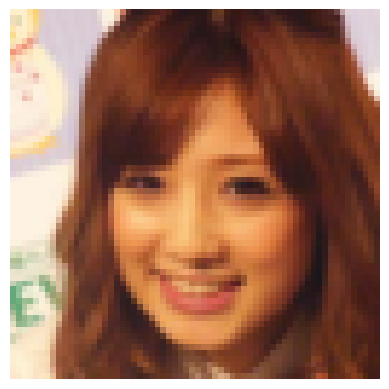

In [ ]:
img = next(iter(train_dl))
show(img[0])

## Building blocks of glow archeticture

What is unique about the glow archeticture is this building blocks of having 3 different invertable differntiable transformations stacked in a block

<img src="https://drive.google.com/uc?id=1XjKO4qzFNMyUbN-AAEYDlinQMwgy2WWv" width="500">

and we will implement them one by one!

starting with actnorm block

### Invertable transformations

[reference 1](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Advanced_Generative_Models/Normalizing_flows/advancednormflow.html)

[reference 2](https://github.com/rosinality/glow-pytorch)

[reference 3](https://arxiv.org/abs/1807.03039)

#### ActNorm

**ActNorm (Activation Normalization):** An affine transformation applied channel-wise (or feature-wise) after an activation function. It's initialized such that the output of the first batch has zero mean and unit variance.


In [ ]:
class ActNorm(nn.Module):
    def __init__(self, num_features, data_format='NCHW'):
        super().__init__()
        self.num_features = num_features
        self.data_format = data_format
        if data_format not in ['NCHW', 'NHWC']:
            raise ValueError(f"Invalid data_format: {data_format}. Must be 'NCHW' or 'NHWC'.")

        # learnable scale and bias parameters, initialized to None
        self.log_scale = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.register_buffer('initialized', torch.tensor(False))

    def forward(self, x, logdet=None):

        """
        Initialization: If the model is in training mode and not yet initialized,
        it calculates the mean and variance of the input batch across the spatial
        dimensions and batch size for each channel. It then initializes log_scale
        and bias such that the output has approximately zero mean and unit variance.
        """
        if self.training and not self.initialized:
            #initialize the learable params on the first batch
            if self.data_format == 'NCHW':
                mean = torch.mean(x.clone().detach(), dim=[0,2,3], keepdim=True)
                var = torch.var(x.clone().detach(), dim=[0,2,3], keepdim=True)
            else:
                mean = torch.mean(x.clone().detach(), dim=[0,1,3], keepdim=True)
                var = torch.var(x.clone().detach(), dim=[0,1,3], keepdim=True)


            self.log_scale.data.copy_(-.5 * torch.log(var+eps))
            self.bias.data.copy_(-mean * torch.exp(self.log_scale))
            self.initialized.fill_(True)

            """
            Normalization: here we apply the affine transformation: y = (x + bias) * scale,
            where scale = exp(log_scale).
            """
        scale = torch.exp(self.log_scale)
        y = (x + self.bias) * scale

        """
        Log Determinant of Jacobian: The Jacobian of this operation is a diagonal matrix with scale
        long the channel dimension. The determinant is the product of these scales over all elements.
        The log determinant is the sum of the log scales over all elements and spatial positions.
        """
        if logdet is not None:
            log_det_jacobian = torch.sum(self.log_scale) * torch.prod(torch.tensor(x.shape[2:]))
            logdet = logdet + log_det_jacobian * torch.ones(x.shape[0], device=x.device)
            return y, logdet
        else:
            return y

    def inverse(self, y, logdet=None):
        """
        Applies the inverse transformation: x = y / scale - bias.
        The log determinant of the inverse Jacobian is the negative
        of the log determinant of the forward Jacobian.
        """
        scale = torch.exp(self.log_scale)
        x = y / scale - self.bias

        if logdet is not None:
            log_det_jacobian = -torch.sum(self.log_scale) * torch.prod(torch.tensor(y.shape[2:]))
            logdet = logdet + log_det_jacobian * torch.ones(y.shape[0], device=y.device)
            return x, logdet
        else:
            return x

    def log_det_jacobian(self, x):
        # For consistency with other layers, although it's computed in forward/inverse
        log_det_j = torch.sum(self.log_scale) * torch.prod(torch.tensor(x.shape[2:]))
        return log_det_j * torch.ones(x.shape[0], device=x.device)

In [ ]:
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

actnorm = ActNorm(channels)
output = actnorm(dummy_input)

print("input shape:", dummy_input.shape)
print("output shape:", output.shape)

# during training, the first forward pass will initialize the parameters
actnorm.train()
first_output = actnorm(dummy_input)
print("iinitialized log_scale:", actnorm.log_scale.data)
print("initialized bias:", actnorm.bias.data)

# subsequent forward passes will use the learned parameters
second_output = actnorm(dummy_input)

# test the inverse
inverse_output = actnorm.inverse(second_output)
print("inverse output shape:", inverse_output.shape)
print("are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-8))

input shape: torch.Size([4, 3, 8, 8])
output shape: torch.Size([4, 3, 8, 8])
iinitialized log_scale: tensor([[[[-0.0708]],

         [[ 0.0380]],

         [[ 0.0395]]]])
initialized bias: tensor([[[[ 0.0159]],

         [[-0.0972]],

         [[-0.1582]]]])
inverse output shape: torch.Size([4, 3, 8, 8])
are input and inverse output close? True


#### Invertible1x1Conv

**Invertible 1x1 Convolution:** A linear transformation using a square invertible matrix applied to the channel dimension. This allows for mixing of channels.

This layer applies a linear transformation to the channel dimension of the input using a square invertible matrix. For an input with C channels, it learns a C * C invertible weight matrix W. The output y is then y=Wx, where x and y are reshaped so the convolution operation corresponds to a matrix multiplication along the channel dimension at each spatial location.

<img src="https://drive.google.com/uc?id=1V2hMJpMXNGNZz6gCJGaVR658J0qxZimd" width="1000">

[reference](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Advanced_Generative_Models/Normalizing_flows/advancednormflow.html)

In [ ]:
from scipy.linalg import lu_factor, lu_solve

class Invertible1x1Conv(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.num_channels = num_channels
        # initialize a random orthonormal matrix for weights
        # this in torch compute the QR decomposition of a matrix
        W = torch.linalg.qr(torch.randn(num_channels, num_channels))[0]
        # what is orthonormal? A matrix whose columns are both orthogonal and normalized
        """
        torch.linalg.qr() performs QR decomposition, where:

        Q is an orthonormal matrix.
        -> one property of orthonormal "Q.T * Q = I" which means the transpose of orthonormal is essential the same as the inverse!
        -> another cool property of Q is that Q is upper triangular

        R is an upper triangular matrix

        torch.linalg.qr(A) returns a tuple (Q, R) and we're taking the Q
        """
        self.weights = nn.Parameter(W)

    def forward(self, x, logdet=None):
        batch_size, n_channels, height, width = x.shape #NCHW

        #reshape and apply 1x1 conv
        w = self.weights.view(n_channels, n_channels, 1,1)
        z = F.conv2d(x, w, stride=1, padding=0)

        if logdet is not None:
            #calc the log det of jacobian ldj
            detW = torch.det(self.weights) #torch.det
            ldj = height * width * torch.log(torch.abs(detW)+eps)
            logdet=logdet + ldj * torch.ones(batch_size,device=x.device)
            return z, logdet
        else:
            return z

    def inverse(self, z, logdet=None):
        batch_size, n_channels, height, width = z.shape

        weight_inv = torch.inverse(self.weights) #here torch.inverse
        w_inv = weight_inv.view(n_channels, n_channels, 1,1 )
        x = F.conv2d(z, w_inv, stride=1, padding=0)

        if logdet is not None:
            detW_inv = torch.det(weight_inv) #torch.det
            ldj = height* width * torch.log(torch.abs(detW_inv)+eps)
            logdet = logdet - ldj * torch.ones(batch_size, device=z.device)
            return x, logdet
        else:
            return x

    def log_det_jacobian(self, x):
        batch_size, n_channels, height, width = x.shape
        detW = torch.det(self.weights) #torch.det
        ldj = height * width * torch.log(torch.abs(detW) + eps)
        return ldj * torch.ones(batch_size, device=x.device)

We've used torch.det and torch.inverse directly for simplicity in my implementation.

In the actual Glow implementation LU decomposition is used for numerical stability and potentially more efficient inverse computation and determinant calculation, especially for larger channel sizes. Implementing LU decomposition in PyTorch can be a bit more involved, often relying on torch.linalg.lu_factor and torch.linalg.lu_solve or similar functions.

Also you will see LU decompsition in the model i took from the repo because it speeds up the convergence substantially better.

hmmmmm you don't know what is LU decompsition? [see this cool vid](https://youtu.be/joDOPaHVDnI?si=5pRynOK0DpNoCZYD)

In [ ]:
# test the Invertible 1x1 Convolution
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

inv_conv = Invertible1x1Conv(channels)
output, logdet = inv_conv(dummy_input, logdet=torch.zeros(batch_size))

print("input shape:", dummy_input.shape)
print("output shape:", output.shape)
print("log determinant:", logdet)

# test the inverse
inverse_output, logdet_inv = inv_conv.inverse(output, logdet=torch.zeros(batch_size))
print("inverse output shape:", inverse_output.shape)
print("inverse log determinant:", logdet_inv)
print("are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-8))
print("is logdet approximately -logdet_inv?", torch.allclose(logdet, -logdet_inv, rtol=1e-5, atol=1e-8))

input shape: torch.Size([4, 3, 8, 8])
output shape: torch.Size([4, 3, 8, 8])
log determinant: tensor([6.1035e-05, 6.1035e-05, 6.1035e-05, 6.1035e-05],
       grad_fn=<AddBackward0>)
inverse output shape: torch.Size([4, 3, 8, 8])
inverse log determinant: tensor([-6.1035e-05, -6.1035e-05, -6.1035e-05, -6.1035e-05],
       grad_fn=<SubBackward0>)
are input and inverse output close? True
is logdet approximately -logdet_inv? True


#### AffineCoupling

**Affine Coupling Layers:** These layers split the input channels and apply an affine transformation to one part conditioned on the other part through a non-linear function.

The affine coupling layer in Glow typically splits the input channels into two parts. Let's say we split the C channels into C_a and C_b channels. The transformation then applies to the C_b part based on a function of the C_a part. The C_a part remains unchanged. This ensures invertibility.


The transformations are of the form:

$$
y_a = x_a \\
y_b = s(x_a) \odot x_b + t(x_a)
$$

where \( s \) is a scaling function and \( t \) is a translation function, both conditioned on \( x_a \).  
⊙ denotes element-wise multiplication.

The inverse is:

$$
x_a = y_a \\
x_b = (y_b - t(y_a)) ⊘ s(y_a)
$$

where ⊘ denotes element-wise division.

In [ ]:
class AffineCoupling(nn.Module):
    def __init__(self, num_channels, mask_type):
        # although i didn't implemented the mask type mechanism to alternate between modes the current one is channel-wise masking
        # i'll try later to implement spatial masking (aka checkerboard masking)

        super().__init__()
        self.num_channels = num_channels
        if num_channels % 2 == 0:
            self.split_dim = num_channels // 2
        else:
            self.split_dim = num_channels // 2 + 1 # make the first part slightly larger for odd
        self.transform_dim = num_channels - self.split_dim
        self.mask_type = mask_type

        # nn to predict scale and translation factors
        self.scale_translate_net = nn.Sequential(
            nn.Conv2d(self.split_dim, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 2 * self.transform_dim, kernel_size=3, padding=1), # output scale and translate
            # nn.Tanh()
        )

        # initialize the last layer to have small weights for near-identity transform initially
        nn.init.zeros_(self.scale_translate_net[-1].weight)
        nn.init.zeros_(self.scale_translate_net[-1].bias)

        # uncomment this if you want the last activation to be tanh
        # self.scale_translate_net[-2].weight.data.mul_(0.1)
        # self.scale_translate_net[-2].bias.data.mul_(0.)

    def forward(self, x, logdet=None):
        split_sizes = [self.split_dim, self.transform_dim]
        x_a, x_b = torch.split(x, split_sizes, dim=1)

        st = self.scale_translate_net(x_a)
        scale, translate = torch.split(st, self.transform_dim, dim=1)
        scale = torch.sigmoid(scale + 2) # Ensure scale is positive

        y_a = x_a
        y_b = scale * x_b + translate

        if (logdet is not None):
            log_det_jacobian = torch.sum(torch.log(scale.abs() + 1e-6), dim=[1, 2, 3])
            logdet = logdet + log_det_jacobian
            return torch.cat([y_a, y_b], dim=1), logdet
        else:
            return torch.cat([y_a, y_b], dim=1)

    def inverse(self, y, logdet=None):
        split_sizes = [self.split_dim, self.transform_dim]
        y_a, y_b = torch.split(y, split_sizes, dim=1)

        st = self.scale_translate_net(y_a)
        scale, translate = torch.split(st, self.transform_dim, dim=1)
        scale = torch.sigmoid(scale + 2)

        x_a = y_a
        x_b = (y_b - translate) / (scale + 1e-6)

        if logdet is not None:
            log_det_jacobian = -torch.sum(torch.log(scale.abs() + 1e-6), dim=[1, 2, 3])
            logdet = logdet + log_det_jacobian
            return torch.cat([x_a, x_b], dim=1), logdet
        else:
            return torch.cat([x_a, x_b], dim=1)

    def log_det_jacobian(self, x):
        split_sizes = [self.split_dim, self.transform_dim]
        x_a, _ = torch.split(x, split_sizes, dim=1)
        st = self.scale_translate_net(x_a)
        scale, _ = torch.split(st, self.transform_dim, dim=1)
        scale = torch.sigmoid(scale + 2)
        log_det_j = torch.sum(torch.log(scale.abs() + 1e-6), dim=[1, 2, 3])
        return log_det_j

In [ ]:
# test the Affine Coupling Layer
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

coupling_layer = AffineCoupling(channels, mask_type='channel')
output, logdet = coupling_layer(dummy_input, logdet=torch.zeros(batch_size))

print("\n--- Testing Affine Coupling Layer ---")
print("input shape:", dummy_input.shape)
print("output shape:", output.shape)
print("log determinant:", logdet)

# test the inverse
inverse_output, logdet_inv = coupling_layer.inverse(output, logdet=torch.zeros(batch_size))
print("inverse output shape:", inverse_output.shape)
print("inverse log determinant:", logdet_inv)
print("are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-8))
print("is logdet approximately -logdet_inv?", torch.allclose(logdet, -logdet_inv, rtol=1e-5, atol=1e-8))


--- Testing Affine Coupling Layer ---
input shape: torch.Size([4, 3, 8, 8])
output shape: torch.Size([4, 3, 8, 8])
log determinant: tensor([-8.1233, -8.1233, -8.1233, -8.1233], grad_fn=<AddBackward0>)
inverse output shape: torch.Size([4, 3, 8, 8])
inverse log determinant: tensor([8.1233, 8.1233, 8.1233, 8.1233], grad_fn=<AddBackward0>)
are input and inverse output close? True
is logdet approximately -logdet_inv? True


#### GlowBlock

Now we will assemble the blocks here, but also will implement squeeze which will decrease the dimensions of the input after a glow block and unsqueeze to undo that in the backward step

and we will implement split which splits and condition the channels like the image (b) below!

<img src="https://drive.google.com/uc?id=1j6S3BcJ8DH3LYH6gHBtf-W9uyAFZCOFq" width="1000">

In [ ]:
class GlowBlock(nn.Module):
    def __init__(self, num_channels, mask_type):
        super().__init__()
        self.num_channels = num_channels
        self.mask_type = mask_type
        self.actnorm = ActNorm(num_channels)
        self.inv_conv = Invertible1x1Conv(num_channels)
        self.affine_coupling = AffineCoupling(num_channels, mask_type)

    def forward(self, x, logdet=None):
        x, logdet = self.actnorm(x, logdet)
        x, logdet = self.inv_conv(x, logdet)
        x, logdet = self.affine_coupling(x, logdet)
        return x, logdet

    def inverse(self, z, logdet=None):
        z, logdet = self.affine_coupling.inverse(z, logdet)
        z, logdet = self.inv_conv.inverse(z, logdet)
        z, logdet = self.actnorm.inverse(z, logdet)
        return z, logdet

In [ ]:
# test the GlowBlock
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

glow_block = GlowBlock(channels, mask_type='channel')
output, logdet = glow_block(dummy_input, logdet=torch.zeros(batch_size))

print("\n--- Testing GlowBlock ---")
print("input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("Log determinant:", logdet)

# Test the inverse
inverse_output, logdet_inv = glow_block.inverse(output, logdet=torch.zeros(batch_size))
print("Inverse output shape:", inverse_output.shape)
print("Inverse log determinant:", logdet_inv)
print("Are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-3))
print("Is logdet approximately -logdet_inv?", torch.allclose(logdet, -logdet_inv, rtol=1e-5, atol=1e-3))


--- Testing GlowBlock ---
input shape: torch.Size([4, 3, 8, 8])
Output shape: torch.Size([4, 3, 8, 8])
Log determinant: tensor([-12.0693, -12.0693, -12.0693, -12.0693], grad_fn=<AddBackward0>)
Inverse output shape: torch.Size([4, 3, 8, 8])
Inverse log determinant: tensor([12.0693, 12.0693, 12.0693, 12.0693], grad_fn=<AddBackward0>)
Are input and inverse output close? True
Is logdet approximately -logdet_inv? True


In [ ]:
class Squeeze(nn.Module):
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        if height % self.factor != 0 or width % self.factor != 0:
            print(f'height {height}, width {width}')
            raise ValueError("height and width must be divisible by the factor.")
        new_height = height // self.factor
        new_width = width // self.factor
        new_channels = channels * (self.factor ** 2)
        # interleave spatial dims into channel dim
        y = x.view(batch_size, channels, new_height, self.factor, new_width, self.factor)
        y = y.permute(0, 1, 3, 5, 2, 4).contiguous()
        y = y.view(batch_size, new_channels, new_height, new_width)
        return y

class Unsqueeze(nn.Module):
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        if channels % (self.factor ** 2) != 0:
            print(f'channels {channels}')
            raise ValueError("channels must be divisible by (factor ** 2).")
        new_channels = channels // (self.factor ** 2)
        new_height = height * self.factor
        new_width = width * self.factor
        # inverse of the squeeze operation
        y = x.view(batch_size, new_channels, self.factor, self.factor, height, width)
        y = y.permute(0, 1, 4, 2, 5, 3).contiguous()
        y = y.view(batch_size, new_channels, new_height, new_width)
        return y

In [ ]:
batch_size = 4
channels = 3
height = 8
width = 8
factor = 2
dummy_input = torch.randn(batch_size, channels, height, width)

squeeze = Squeeze(factor)
squeezed_output = squeeze(dummy_input)
print("\n--- Testing Squeeze ---")
print("input shape:", dummy_input.shape)
print("squeezed output shape:", squeezed_output.shape)

unsqueeze = Unsqueeze(factor)
unsqueezed_output = unsqueeze(squeezed_output)
print("\n--- Testing Unsqueeze ---")
print("unsqueezed output shape:", unsqueezed_output.shape)
print("are input and unsqueezed output close?", torch.allclose(dummy_input, unsqueezed_output, rtol=1e-5, atol=1e-8))

# Test with a different factor
factor = 4
dummy_input_large = torch.randn(batch_size, channels, 16, 16)
squeeze_large = Squeeze(factor)
squeezed_output_large = squeeze_large(dummy_input_large)
print("\n--- Testing Squeeze with factor 4 ---")
print("input shape:", dummy_input_large.shape)
print("squeezed output shape:", squeezed_output_large.shape)

unsqueeze_large = Unsqueeze(factor)
unsqueezed_output_large = unsqueeze_large(squeezed_output_large)
print("\n--- Testing Unsqueeze with factor 4 ---")
print("unsqueezed output shape:", unsqueezed_output_large.shape)
print("are input and unsqueezed output close?", torch.allclose(dummy_input_large, unsqueezed_output_large, rtol=1e-5, atol=1e-8))


--- Testing Squeeze ---
input shape: torch.Size([4, 3, 8, 8])
squeezed output shape: torch.Size([4, 12, 4, 4])

--- Testing Unsqueeze ---
unsqueezed output shape: torch.Size([4, 3, 8, 8])
are input and unsqueezed output close? True

--- Testing Squeeze with factor 4 ---
input shape: torch.Size([4, 3, 16, 16])
squeezed output shape: torch.Size([4, 48, 4, 4])

--- Testing Unsqueeze with factor 4 ---
unsqueezed output shape: torch.Size([4, 3, 16, 16])
are input and unsqueezed output close? True


In [ ]:
class Split(nn.Module):
    def __init__(self, num_channels, split_factor=2):
        super().__init__()
        if num_channels % split_factor != 0:
            raise ValueError(f"number of channels ({num_channels}) must be divisible by the split factor ({split_factor}).")
        self.split_factor = split_factor
        self.out_channels = num_channels // split_factor

    def forward(self, x, logdet=None):
        z1 = x[:, :self.out_channels, :, :]
        z2 = x[:, self.out_channels:, :, :]
        if logdet is not None:
            return (z1, z2), logdet
        else:
            return (z1, z2)

class Unsplit(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels

    def forward(self, z1, z2, logdet=None):
        x = torch.cat([z1, z2], dim=1)
        if logdet is not None:
            return x, logdet
        else:
            return x

In [ ]:
batch_size = 4
in_channels = 12
height = 8
width = 8
split_factor = 2

# dummy input tensor
dummy_input = torch.randn(batch_size, in_channels, height, width)

# instantiate split and perform forward pass
split_layer = Split(in_channels, split_factor)
z1, z2 = split_layer(dummy_input)

print("--- Testing Isolated Split ---")
print("input shape:", dummy_input.shape)
print("z1 shape:", z1.shape)
print("z2 shape:", z2.shape)

# instantiate unsplit and perform forward pass
unsplit_layer = Unsplit(in_channels)
reconstructed_x = unsplit_layer(z1, z2)

print("\n--- Testing Isolated Unsplit ---")
print("Reconstructed x shape:", reconstructed_x.shape)
print("Are input and reconstructed x close?", torch.allclose(dummy_input, reconstructed_x, rtol=1e-5, atol=1e-8))

# test with odd number of initial channels (should raise ValueError in Split)
try:
    split_odd = Split(7)
except ValueError as e:
    print(f"\n--- Testing Split with odd channels ---")
    print(f"Caught expected error: {e}")

# test unsplit with mismatched input sizes
mismatched_z2 = torch.randn(batch_size, z2.shape[1] + 1, height, width)
try:
    unsplit_mismatch = Unsplit(in_channels + 1) # initialize with the expected output channels
    reconstructed_mismatch = unsplit_mismatch(z1, mismatched_z2)
except RuntimeError as e:
    print(f"\n--- Testing Unsplit with mismatched sizes ---")
    print(f"Caught expected error: {e}")

--- Testing Isolated Split ---
input shape: torch.Size([4, 12, 8, 8])
z1 shape: torch.Size([4, 6, 8, 8])
z2 shape: torch.Size([4, 6, 8, 8])

--- Testing Isolated Unsplit ---
Reconstructed x shape: torch.Size([4, 12, 8, 8])
Are input and reconstructed x close? True

--- Testing Split with odd channels ---
Caught expected error: number of channels (7) must be divisible by the split factor (2).


## The glow model ^-^

In [ ]:
class GlowModel(nn.Module):
    def __init__(self, num_channels, image_size, num_blocks, num_levels, factor=2):
        super().__init__()
        self.num_channels = num_channels
        self.image_size = image_size
        self.num_blocks = num_blocks
        self.num_levels = num_levels
        self.factor = factor

        self.layers = nn.ModuleList()
        current_channels = num_channels
        current_size = image_size

        for level in range(num_levels):
            for _ in range(num_blocks):
                self.layers.append(GlowBlock(current_channels, mask_type='channel'))
            if level < num_levels - 1:
                self.layers.append(Squeeze(factor))
                current_channels *= (factor ** 2)
                current_size //= factor
                self.layers.append(Split(current_channels))
                current_channels //= 2 # After split, the remaining part has half the channels

        self.n_latent_variables = self.calculate_latent_size(num_channels, image_size, num_levels, factor)

    def calculate_latent_size(self, initial_channels, initial_size, num_levels, factor):
        channels = initial_channels
        size = initial_size
        latent_size = 0
        for level in range(num_levels):
            if level < num_levels - 1:
                channels *= (factor ** 2)
                size //= factor
                latent_size += (channels // 2) * (size ** 2)
                channels //= 2
            else:
                latent_size += channels * (size ** 2)
        return latent_size

    def forward(self, x, logdet=None):
        all_z = []
        current_x = x
        current_logdet = logdet

        for layer in self.layers:
            if isinstance(layer, GlowBlock):
                current_x, current_logdet = layer(current_x, current_logdet)
            elif isinstance(layer, Squeeze):
                current_x = layer(current_x)
            elif isinstance(layer, Split):
                split_output = layer(current_x, current_logdet)
                if logdet is not None:
                    current_x, z = split_output[0]
                    current_logdet = split_output[1]
                else:
                    current_x, z = split_output
                all_z.append(z)

        all_z.append(current_x) # The final remaining part is also latent
        return all_z, current_logdet

    def inverse(self, z_list, logdet=None):
        current_x = z_list[-1]
        current_logdet = logdet
        # print("Inverse Initial z Shape:", current_x.shape)

        reversed_layers = list(reversed(self.layers))
        z_index = len(z_list) - 2 # Start from the second to last z

        for layer in reversed_layers:
            # print("Inverse Layer:", layer.__class__.__name__, "Input Shape:", current_x.shape)
            if isinstance(layer, GlowBlock):
                current_x, current_logdet = layer.inverse(current_x, current_logdet)
            elif isinstance(layer, Squeeze):
                current_x = Unsqueeze(self.factor)(current_x)
            elif isinstance(layer, Split):
                z = z_list[z_index]
                # print(f"Accessing z (index {z_index}) shape:", z.shape)
                out_channels = current_x.shape[1] + z.shape[1]
                current_x = Unsplit(out_channels)(current_x, z)
                z_index -= 1

        return current_x, current_logdet


In [ ]:
num_channels = 3        # For RGB images
image_size = size       # Example image size
num_blocks = 1          # Number of GlowBlocks per level
num_levels = 10         # Number of multi-scale levels
factor = 2              # Squeeze factor

glow_model = GlowModel(num_channels, image_size, num_blocks, num_levels, factor)
print(glow_model)

GlowModel(
  (layers): ModuleList(
    (0): GlowBlock(
      (actnorm): ActNorm()
      (inv_conv): Invertible1x1Conv()
      (affine_coupling): AffineCoupling(
        (scale_translate_net): Sequential(
          (0): Conv2d(2, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (1): Squeeze()
    (2): Split()
    (3): GlowBlock(
      (actnorm): ActNorm()
      (inv_conv): Invertible1x1Conv()
      (affine_coupling): AffineCoupling(
        (scale_translate_net): Sequential(
          (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(512, 6, kernel_size=(3, 3), stride=(1, 1), paddi

        """
                             K                                      K
        --> [GlowBlock] -> [Squeeze] -> [GlowBlock] -> [Split] -> [Squeeze] -> [GlowBlock]
                                ^                           v
                                |          (L - 1)          |
                                + --------------------------+
        """

In [ ]:
all_params = sum(p.numel() for p in glow_model.parameters())
print(f"Total parameters (trainable + non-trainable): {all_params:,}")

Total parameters (trainable + non-trainable): 37,336,377


## The working glow model credit to [rosinality](https://github.com/rosinality/glow-pytorch)!
i took the whole implemenation from their notebook and made some small modifications to have it work on colab.

but uhm i trained the model you will see the results of.

### Invertable transformations

#### ActNorm

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from math import log, pi, exp
import numpy as np
from scipy import linalg as la

logabs = lambda x: torch.log(torch.abs(x))


class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()

        self.loc = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_channel, 1, 1))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1, 0, 2, 3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )

            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))

    def forward(self, input):
        _, _, height, width = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)

        log_abs = logabs(self.scale)

        logdet = height * width * torch.sum(log_abs)

        if self.logdet:
            return self.scale * (input + self.loc), logdet

        else:
            return self.scale * (input + self.loc)

    def reverse(self, output):
        return output / self.scale - self.loc


class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=0)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))

    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)

        return out

#### Invertible1x1Conv

In [ ]:
class InvConv2d(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(weight)
        weight = q.unsqueeze(2).unsqueeze(3)
        self.weight = nn.Parameter(weight)

    def forward(self, input):
        _, _, height, width = input.shape

        out = F.conv2d(input, self.weight)
        logdet = (
            height * width * torch.slogdet(self.weight.squeeze().double())[1].float()
        )

        return out, logdet

    def reverse(self, output):
        return F.conv2d(
            output, self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)
        )


class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32))
        w_s = np.diag(w_u)
        w_u = np.triu(w_u, 1)
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T

        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)

        self.register_buffer("w_p", w_p)
        self.register_buffer("u_mask", torch.from_numpy(u_mask))
        self.register_buffer("l_mask", torch.from_numpy(l_mask))
        self.register_buffer("s_sign", torch.sign(w_s))
        self.register_buffer("l_eye", torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)

    def forward(self, input):
        _, _, height, width = input.shape

        weight = self.calc_weight()

        out = F.conv2d(input, weight)
        logdet = height * width * torch.sum(self.w_s)

        return out, logdet

    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )

        return weight.unsqueeze(2).unsqueeze(3)

    def reverse(self, output):
        weight = self.calc_weight()

        return F.conv2d(output, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))

#### AffineCoupling

In [ ]:
class AffineCoupling(nn.Module):
    def __init__(self, in_channel, filter_size=512, affine=True):
        super().__init__()

        self.affine = affine

        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, filter_size, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(filter_size, in_channel if self.affine else in_channel // 2),
        )

        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()

        self.net[2].weight.data.normal_(0, 0.05)
        self.net[2].bias.data.zero_()

    def forward(self, input):
        in_a, in_b = input.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(in_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # out_a = s * in_a + t
            out_b = (in_b + t) * s

            logdet = torch.sum(torch.log(s).view(input.shape[0], -1), 1)

        else:
            net_out = self.net(in_a)
            out_b = in_b + net_out
            logdet = None

        return torch.cat([in_a, out_b], 1), logdet

    def reverse(self, output):
        out_a, out_b = output.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(out_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # in_a = (out_a - t) / s
            in_b = out_b / s - t

        else:
            net_out = self.net(out_a)
            in_b = out_b - net_out

        return torch.cat([out_a, in_b], 1)

#### FlowBlock

In [ ]:
class Flow(nn.Module):
    def __init__(self, in_channel, affine=True, conv_lu=True):
        super().__init__()

        self.actnorm = ActNorm(in_channel)

        if conv_lu:
            self.invconv = InvConv2dLU(in_channel)

        else:
            self.invconv = InvConv2d(in_channel)

        self.coupling = AffineCoupling(in_channel, affine=affine)

    def forward(self, input):
        out, logdet = self.actnorm(input)
        out, det1 = self.invconv(out)
        out, det2 = self.coupling(out)

        logdet = logdet + det1
        if det2 is not None:
            logdet = logdet + det2

        return out, logdet

    def reverse(self, output):
        input = self.coupling.reverse(output)
        input = self.invconv.reverse(input)
        input = self.actnorm.reverse(input)

        return input


def gaussian_log_p(x, mean, log_sd):
    return -0.5 * log(2 * pi) - log_sd - 0.5 * (x - mean) ** 2 / torch.exp(2 * log_sd)


def gaussian_sample(eps, mean, log_sd):
    return mean + torch.exp(log_sd) * eps

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channel, n_flow, split=True, affine=True, conv_lu=True):
        super().__init__()

        squeeze_dim = in_channel * 4

        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim, affine=affine, conv_lu=conv_lu))

        self.split = split

        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)

        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)

    def forward(self, input):
        b_size, n_channel, height, width = input.shape
        squeezed = input.view(b_size, n_channel, height // 2, 2, width // 2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        out = squeezed.contiguous().view(b_size, n_channel * 4, height // 2, width // 2)

        logdet = 0

        for flow in self.flows:
            out, det = flow(out)
            logdet = logdet + det

        if self.split:
            out, z_new = out.chunk(2, 1)
            mean, log_sd = self.prior(out).chunk(2, 1)
            log_p = gaussian_log_p(z_new, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)

        else:
            zero = torch.zeros_like(out)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p = gaussian_log_p(out, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            z_new = out

        return out, logdet, log_p, z_new

    def reverse(self, output, eps=None, reconstruct=False):
        input = output

        if reconstruct:
            if self.split:
                input = torch.cat([output, eps], 1)

            else:
                input = eps

        else:
            if self.split:
                mean, log_sd = self.prior(input).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = torch.cat([output, z], 1)

            else:
                zero = torch.zeros_like(input)
                # zero = F.pad(zero, [1, 1, 1, 1], value=1)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = z

        for flow in self.flows[::-1]:
            input = flow.reverse(input)

        b_size, n_channel, height, width = input.shape

        unsqueezed = input.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(
            b_size, n_channel // 4, height * 2, width * 2
        )

        return unsqueezed

### The glow model

In [ ]:
class Glow(nn.Module):
    def __init__(
        self, in_channel, n_flow, n_block, affine=True, conv_lu=True
    ):
        super().__init__()

        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(Block(n_channel, n_flow, affine=affine, conv_lu=conv_lu))
            n_channel *= 2
        self.blocks.append(Block(n_channel, n_flow, split=False, affine=affine))

    def forward(self, input):
        log_p_sum = 0
        logdet = 0
        out = input
        z_outs = []

        for block in self.blocks:
            out, det, log_p, z_new = block(out)
            z_outs.append(z_new)
            logdet = logdet + det

            if log_p is not None:
                log_p_sum = log_p_sum + log_p

        return log_p_sum, logdet, z_outs

    def reverse(self, z_list, reconstruct=False):
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0:
                input = block.reverse(z_list[-1], z_list[-1], reconstruct=reconstruct)

            else:
                input = block.reverse(input, z_list[-(i + 1)], reconstruct=reconstruct)

        return input

this is how the archeticture looks like

        """
                             K                                      K
        --> [Squeeze] -> [FlowStep] -> [Split] -> [Squeeze] -> [FlowStep]
               ^                           v
               |          (L - 1)          |
               + --------------------------+
        """

## Training!

Since we already know the components of the glow i hide the code so you can see the output of a working glow model!

In [ ]:
#@title #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = SimpleNamespace(
    batch=64,
    iter=5000,
    n_flow=32,
    n_block=4,
    no_lu=False,
    affine=False,
    n_bits=5,
    lr=1e-4,
    img_size=64,
    temp=0.7,
    n_sample=20,
)

os.makedirs("sample", exist_ok=True)
os.makedirs("checkpoint", exist_ok=True)

def calc_z_shapes(n_channel, input_size, n_flow, n_block):
    z_shapes = []
    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2
        z_shapes.append((n_channel, input_size, input_size))
    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))
    return z_shapes

def calc_loss(log_p, logdet, image_size, n_bins):
    n_pixel = image_size * image_size * 3
    loss = -log(n_bins) * n_pixel + logdet + log_p
    return (
        (-loss / (log(2) * n_pixel)).mean(),
        (log_p / (log(2) * n_pixel)).mean(),
        (logdet / (log(2) * n_pixel)).mean(),
    )

In [ ]:
#@title #
model = Glow(3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu)
model = model.to(device)
model_single = model

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

n_bins = 2.0 ** args.n_bits
z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
z_sample = [torch.randn(args.n_sample, *z).to(device) * args.temp for z in z_shapes]

<ipython-input-19-e42efd4b83d8>:40: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  w_s = torch.from_numpy(w_s)


In [ ]:
#@title important notes here, read the comments I left

data_iter = iter(train_dl)
with tqdm(range(args.iter)) as pbar:
    for i in pbar:
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(train_dl)
            batch = next(data_iter)

        if isinstance(batch, (tuple, list)):
            image = batch[0]
        else:
            image = batch

        image = image.to(device)
        # You might ask why converting the images from [0,1] to [0,255] right? seems unecessary
        image = image * 255

        # But the original paper and the repo here unlike my implementation, will quantize then normalize again
        # glow here quantization via n_bits
        if args.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - args.n_bits))

        #this line normalizes the images which expects the images to be in integers [0,255] priorly
        image = image / n_bins - 0.5

        if i == 0:
            with torch.no_grad():
                _ = model(image + torch.rand_like(image) / n_bins)
            continue

        log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)
        logdet = logdet.mean()

        loss, log_p_val, log_det_val = calc_loss(log_p, logdet, args.img_size, n_bins)

        model.zero_grad()
        loss.backward()
        optimizer.param_groups[0]["lr"] = args.lr
        optimizer.step()

        pbar.set_description(
            f"Loss: {loss.item():.5f}; logP: {log_p_val.item():.5f}; logdet: {log_det_val.item():.5f}"
        )

        if i % 100 == 0:
            with torch.no_grad():
                sample = model_single.reverse(z_sample).cpu().data
                utils.save_image(
                    sample,
                    f"sample/{str(i + 1).zfill(6)}.png",
                    normalize=True,
                    nrow=5,
                    value_range=(-0.5, 0.5),
                )

        if i % 1000 == 0:
            torch.save(model.state_dict(), f"checkpoint/model_{str(i + 1).zfill(6)}.pt")
            torch.save(optimizer.state_dict(), f"checkpoint/optim_{str(i + 1).zfill(6)}.pt")

Loss: 1.43684; logP: -1.83687; logdet: 5.40003: 100%|██████████| 5000/5000 [1:45:58<00:00,  1.27s/it]


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
flush_gpu()

[Before] Allocated: 22145.72 MB | Reserved: 22296.00 MB
[After]  Allocated: 22145.72 MB | Reserved: 22296.00 MB


## Interactions

the gif below shows the model's learning journey from epoch 0 to epoch 10

generating a batch of images every 100 steps

In [ ]:
#@title i followed https://github.com/chaiyujin/glow-pytorch parameters attempt using 64x64 image size
display(IPyImage(filename='/content/glow/training_glow.gif'))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title the result from the original repo
display(IPyImage(filename='/content/glow/progression.gif'))

Output hidden; open in https://colab.research.google.com to view.

### a unique problem to Glow normalizing flows

<img src="https://drive.google.com/uc?id=13xSQKeJ1Ina1q9ZId509vPHy1G-Oibh0" width="1000">

[refernce](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Advanced_Generative_Models/Normalizing_flows/advancednormflow.html)

In [ ]:
failed_model = Glow(3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu)
failed_model = failed_model.to(device)

# optimizer = optim.Adam(model1.parameters(), lr=args.lr)
model_path = "/content/glow/model_000002.pt"  # has converged to have weights that formed a singular matrix which is not invertable:(
optim_path = "/content/glow/optim_000002.pt"
failed_model.load_state_dict(torch.load(model_path, map_location=device))
# optimizer.load_state_dict(torch.load(optim_path, map_location=device))

In [ ]:
#@title this will yield an error
_ = generate_from_latent(failed_model, temp=0, img_size=64, n_flow=32, n_block=4, n_sample=20, plotting=True)

Finale: you can condition the model as shown in previous tutorials conditioning allows control on certain features such as growing beard, youthness, gender, etc...

but the openAI team did something else, which is interpolating the latent space

<img src="https://drive.google.com/uc?id=1EX9t0ES2MqX_u1BW9rF_mMgZrUtEe7nU" width="500">

and here is the page for their model [link](https://openai.com/index/glow/)

## Generating and playground

In [ ]:
#@title loading the model
model1 = Glow(3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu)
model1 = model1.to(device)
model_single = model1

if torch.cuda.device_count() > 1:
    model1 = nn.DataParallel(model1)

# optimizer1 = optim.Adam(model1.parameters(), lr=args.lr)
model_path = "/content/glow/model_005001.pt"
optim_path = "/content/glow/optim_005001.pt"
model1.load_state_dict(torch.load(model_path, map_location=device))
# optimizer1.load_state_dict(torch.load(optim_path, map_location=device))

<ipython-input-38-e42efd4b83d8>:40: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  w_s = torch.from_numpy(w_s)


<All keys matched successfully>

In [ ]:
model = model1

#### Interpolating with attributes

In [ ]:
#@title loading celeba with attribs

import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)
root = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
attr_file = '/kaggle/input/celeba-dataset/list_attr_celeba.csv'

import pandas as pd

df = pd.read_csv(attr_file)
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3

df["Hair_Color"] = df.apply(haircolor,axis=1)
df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]
"""
replacing -1 with 0 without affecting the the 1 values
"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0))
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))
np_attr_matrix = df.to_numpy()[:, 1:]
np_attr = np_attr_matrix.astype(np.float32)
np_attr
transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])

class CustomData(Dataset):
    def __init__(self, root, attr_matrix, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

        #cleaning the attributes
        self.attributes = torch.from_numpy(attr_matrix).to(torch.float32)

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)

        attr = self.attributes[idx]

        return img, attr

datasetc = CustomData(root, np_attr, transforms)
len(datasetc)

<ipython-input-55-f5d7c86888b2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0))
<ipython-input-55-f5d7c86888b2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Male = df.Male.apply(lambda x: max(x,0))


202599

In [ ]:
#@title latent helpers
def encode_latents(model, batch):
    model.eval()
    with torch.no_grad():
        all_z = [model(x.to(device))[2] for x in batch]  # get z_outs
    return all_z

def average_latents(z_list_batch):
    n_levels = len(z_list_batch[0])
    avg = []
    for i in range(n_levels):
        avg_level = torch.stack([z[i] for z in z_list_batch]).mean(dim=0)
        avg.append(avg_level)
    return avg

def manipulate(model, x_input, z_direction, alpha=1.0):
    with torch.no_grad():
        z_input = model(x_input.to(device))[2]
        z_mod = [zi + alpha * d for zi, d in zip(z_input, z_direction)]
        x_mod = model.reverse(z_mod)
    return x_mod.cpu()

In [ ]:
#@title pipeline
def manipulate_attribute_grid(
    model,
    dataset,
    attr_index,
    attr_value_pos,
    attr_value_neg=None,
    n_pos=50,
    n_neg=50,
    alphas=None,
    x_input_index=15000,
    device='cuda'
):
    import torch
    import torchvision.utils as vutils
    from PIL import Image
    import matplotlib.pyplot as plt

    if alphas is None:
        alphas = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

    model.eval()

    # --- Subset selection ---
    def select_subset(dataset, attr_index, attr_value, max_samples=100):
        subset = []
        for i in range(len(dataset)):
            img, attr = dataset[i]
            if attr[attr_index].item() == attr_value:
                subset.append(img.unsqueeze(0))
            if len(subset) >= max_samples:
                break
        return subset

    def select_neg_subset(dataset, attr_index, pos_value, max_samples=100):
        subset = []
        for i in range(len(dataset)):
            img, attr = dataset[i]
            if attr[attr_index].item() != pos_value:
                subset.append(img.unsqueeze(0))
            if len(subset) >= max_samples:
                break
        return subset

    X_pos = select_subset(dataset, attr_index, attr_value_pos, n_pos)
    X_neg = (
        select_subset(dataset, attr_index, attr_value_neg, n_neg)
        if attr_value_neg is not None
        else select_neg_subset(dataset, attr_index, attr_value_pos, n_neg)
    )

    # --- Encode latents ---
    def encode_latents(model, batch):
        with torch.no_grad():
            z_list = []
            for x in batch:
                z_outs = model(x.to(device))[2]
                z_list.append(z_outs)
        return z_list

    def average_latents(z_batch):
        n_levels = len(z_batch[0])
        return [torch.stack([z[i] for z in z_batch]).mean(dim=0) for i in range(n_levels)]

    z_pos = average_latents(encode_latents(model, X_pos))
    z_neg = average_latents(encode_latents(model, X_neg))
    z_direction = [zp - zn for zp, zn in zip(z_pos, z_neg)]

    # --- Manipulate input across alphas ---
    x_input, _ = dataset[x_input_index]

    def manipulate(model, x_input, z_direction, alpha):
        with torch.no_grad():
            z_input = model(x_input.unsqueeze(0).to(device))[2]
            z_mod = [zi + alpha * d for zi, d in zip(z_input, z_direction)]
            x_output = model.reverse(z_mod)
        return x_output.squeeze(0).cpu()

    manipulated_images = [manipulate(model, x_input, z_direction, alpha) for alpha in alphas]

    # Add original for comparison at alpha = 0
    all_images = manipulated_images
    titles = [f"α={alpha:.1f}" for alpha in alphas]

    # --- Plot grid ---
    plt.figure(figsize=(len(all_images) * 2, 3))
    for i, (img, title) in enumerate(zip(all_images, titles)):
        plt.subplot(1, len(all_images), i + 1)
        img = img.clamp(0, 1)  # since CelebA is in [0,1]
        plt.imshow(img.permute(1, 2, 0))
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


##### 🔧 Parameter Guide for `manipulate_attribute_grid`

- `attr_index=0`:  
  Specifies which attribute to manipulate.  
  - `0` corresponds to **Hair_Color** in the dataset.
  - You can use other indices for different attributes if your dataset supports them:
    - `1`: Pale_Skin
    - `2`: Male
    - `3`: No_Beard

- `attr_value_pos=0`:  
  The **positive class value** for the selected attribute.  
  - For Hair_Color:
    - `0`: Blonde
    - `1`: Brown
    - `2`: Black
    - `3`: Other

- `n_pos=50`:  
  Number of **positive examples** to average over when computing the latent direction.

- `n_neg=50`:  
  Number of **negative examples** to average over.  
  - If `attr_value_neg` is not specified, any sample that doesn't match `attr_value_pos` will be used as negative.

- `alphas=[-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]`:  
  List of **manipulation strengths**.  
  - `alpha=0.0`: no change  
  - Negative values: push *away* from the positive attribute  
  - Positive values: push *toward* the positive attribute  
  - More extreme values lead to stronger transformations


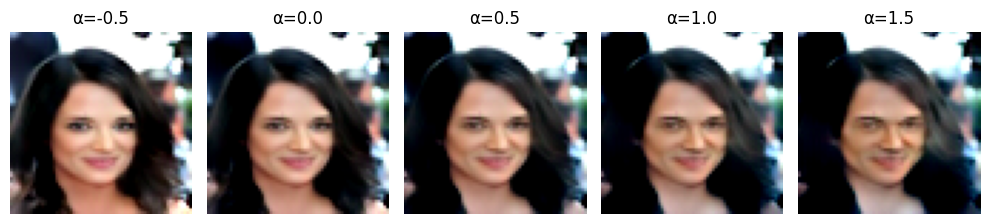

In [ ]:
#@title female to male
manipulate_attribute_grid(
    model=model,
    dataset=datasetc,
    attr_index=2,           # gender male
    attr_value_pos=1,       # start from female
    n_pos=50,
    n_neg=50,
    alphas=[-0.5, 0.0, 0.5, 1.0, 1.5],  # Range of manipulation strengths
    x_input_index=81290,
    device='cuda'
)


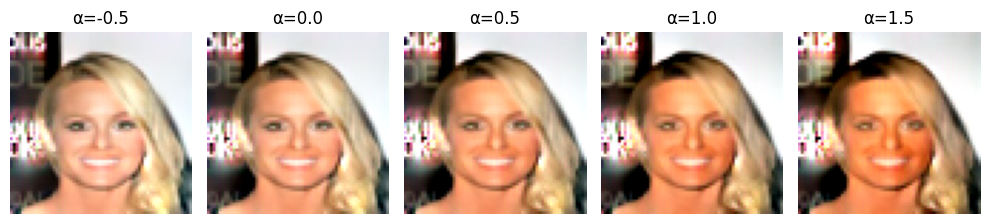

In [ ]:
#@title paleness
manipulate_attribute_grid(
    model=model,
    dataset=datasetc,
    attr_index=1,           # pale
    attr_value_pos=0,       # from pale to dark
    n_pos=50,
    n_neg=50,
    alphas=[-0.5, 0.0, 0.5, 1.0, 1.5],  # Range of manipulation strengths
    x_input_index=124611,
    device='cuda'
)


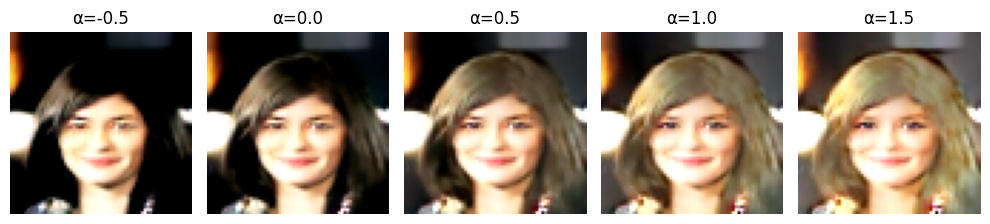

In [ ]:
#@title black to blonde
manipulate_attribute_grid(
    model=model,
    dataset=datasetc,
    attr_index=0,           # Hair_Color
    attr_value_pos=2,       #
    n_pos=50,
    n_neg=50,
    alphas=[-0.5, 0.0, 0.5, 1.0, 1.5],  # Range of manipulation strengths
    x_input_index=8388,
    device='cuda'
)


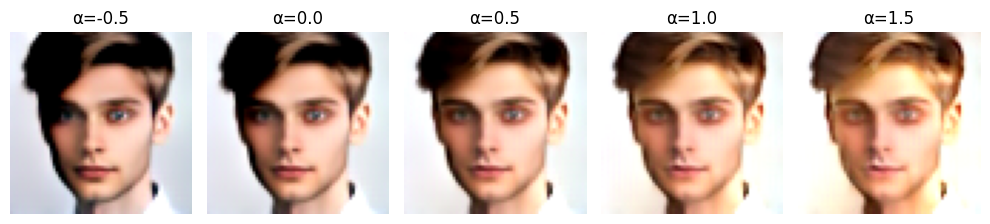

In [ ]:
#@title try with your own images
manipulate_attribute_from_path(
    model=model,
    dataset=datasetc,
    image_path="face5.png",  # your uploaded image
    attr_index=0,             # hair color
    attr_value_pos=0,         # From the current hair color to blonde (0)
    n_pos=50,
    n_neg=50,
    alphas=[-0.5, 0.0, 0.5, 1.0, 1.5],
    device='cuda'
)

#### Interpolating faces

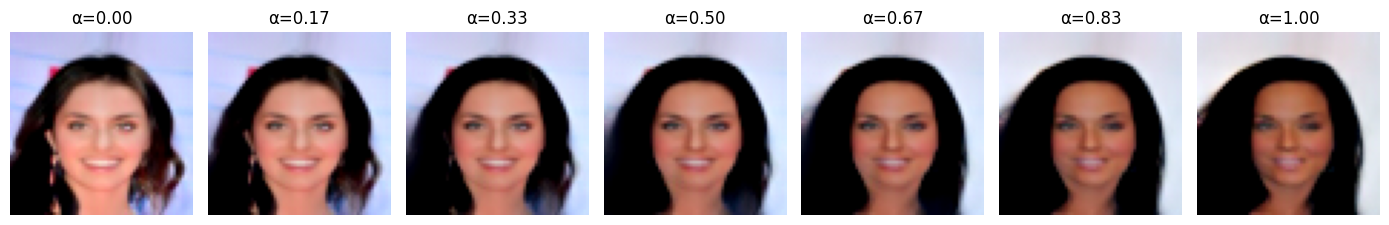

In [ ]:
#@title interpolating two faces
interpolate_faces_dataset(model, datasetc, index1=42, index2=46, num_steps=7, device='cuda')

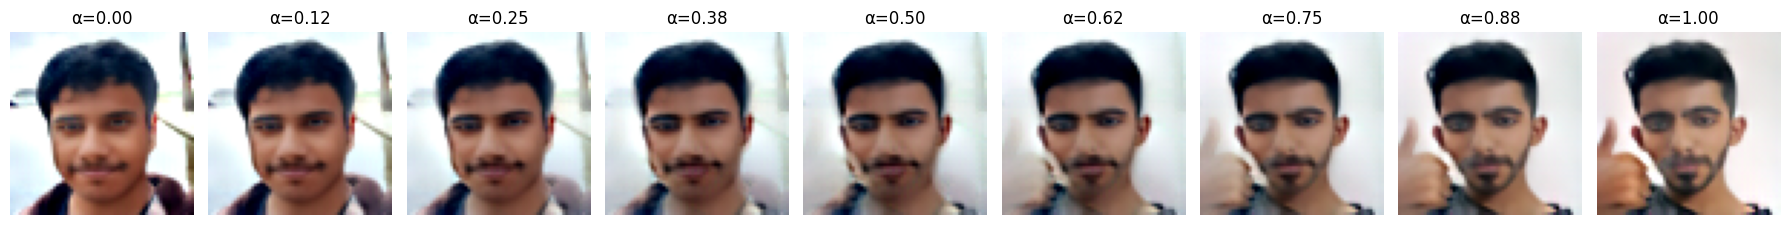

In [ ]:
#@title try with your own images!!
interpolate_from_paths(model, "./face4.jpeg", "./face3.jpeg", num_steps=9)

### Generating from random latents

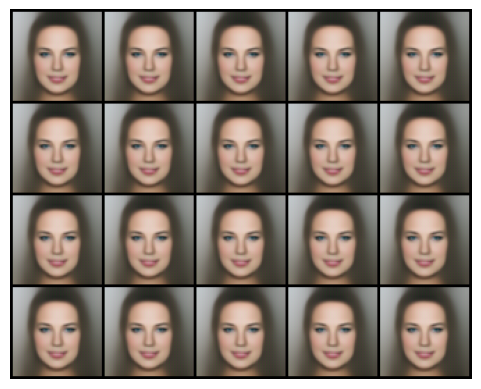

In [ ]:
_ = generate_from_latent(model1, temp=0, img_size=64, n_flow=32, n_block=4, n_sample=20, plotting=True)

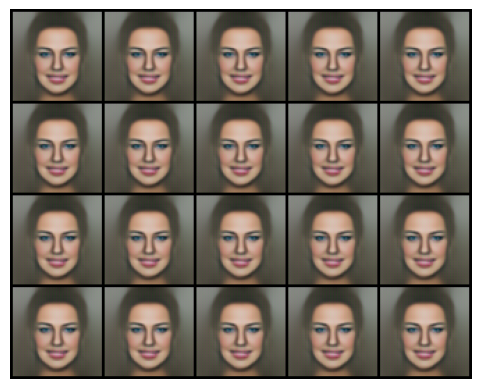

In [ ]:
_ = generate_from_latent(model, temp=0, img_size=64, n_flow=32, n_block=4, n_sample=20, plotting=True)

In [ ]:
shutil.rmtree('/content/visualization')

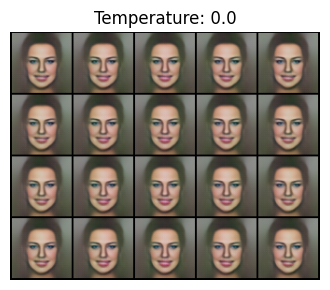

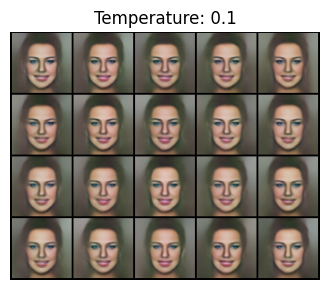

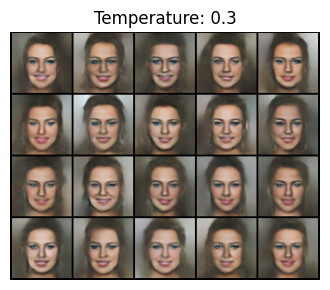

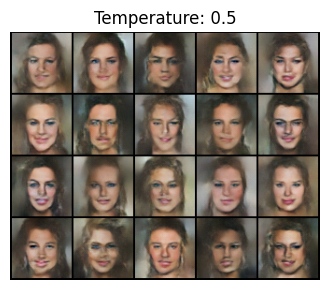

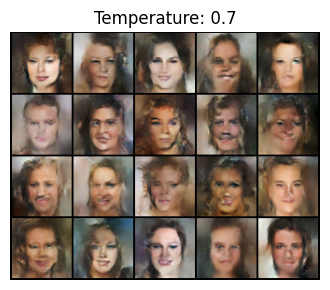

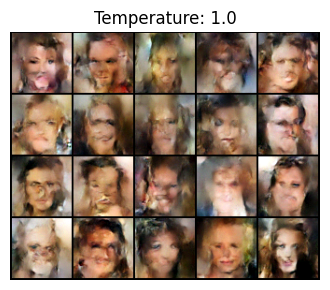

In [ ]:
temps = [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]

for temp in temps:
    img_paths = generate_from_latent(model, temp=temp, img_size=64, n_flow=32, n_block=4, n_sample=20, plotting=False)

    plt.figure(figsize=(4, 4))
    plt.imshow(Image.open(img_paths[-1]))
    plt.title(f"Temperature: {temp}")
    plt.axis('off')
    plt.show()
